In [1]:
import pickle
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open("../input/smart-reply-sentence-similarity/input_texts.pickle", 'rb') as handle:
    input_texts = pickle.load(handle)

In [3]:
tqdm.pandas()
df = pd.read_csv("../input/smart-reply-sentence-similarity/input_similarity_matrix.txt", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,[0.0,0.074744,0.045950,0.035581,0.025370,0.023982,0.021197,0.130980,0.091034,0.117176,...,0.032162,0.040505,0.049052,0.042410,0.059579,0.043003,0.037124,0.025592,0.068595,0.025071442127227783]
1,[0.07474392652511597,0.000000,0.124561,0.094739,0.091702,0.078830,0.077911,0.061102,0.035418,0.068098,...,0.047469,0.058484,0.057926,0.108925,0.060776,0.041573,0.063892,0.109318,0.046864,0.08722186088562012]
2,[0.045949578285217285,0.124561,0.000000,0.061138,0.059595,0.077473,0.077018,0.170005,0.135998,0.135942,...,0.063477,0.075599,0.062363,0.038272,0.077412,0.077282,0.069220,0.050638,0.091718,0.07925379276275635]
3,[0.03558081388473511,0.094739,0.061138,0.000000,0.025638,0.032941,0.036088,0.140010,0.111255,0.141542,...,0.031244,0.053850,0.075226,0.031101,0.074673,0.063433,0.046107,0.023988,0.084816,0.033175528049468994]
4,[0.025369763374328613,0.091702,0.059595,0.025638,0.000000,0.030142,0.027131,0.129845,0.104644,0.133082,...,0.036167,0.029977,0.068582,0.031704,0.064594,0.058782,0.036718,0.022870,0.073135,0.02970707416534424]


In [4]:
# first and last column data contains [ and ]
df.iloc[:,0]

0                        [0.0
1        [0.07474392652511597
2       [0.045949578285217285
3        [0.03558081388473511
4       [0.025369763374328613
                ...          
4996     [0.04300349950790405
4997     [0.03712385892868042
4998     [0.02559220790863037
4999     [0.06859451532363892
5000    [0.025071442127227783
Name: 0, Length: 5001, dtype: object

In [5]:
df.iloc[:,-1:]

,5000
0,0.025071442127227783]
1,0.08722186088562012]
2,0.07925379276275635]
3,0.033175528049468994]
4,0.02970707416534424]
...,...
4996,0.05578291416168213]
4997,0.044557034969329834]
4998,0.023440539836883545]
4999,0.0894964337348938]


In [6]:
# cleaning first and last columns
df.iloc[:,0] = df.iloc[:,0].str.replace("[", "").str.strip()
df.iloc[:,-1:] = df.iloc[:,-1].str.replace("]", "").str.strip()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
df.iloc[:,0]

0                        0.0
1        0.07474392652511597
2       0.045949578285217285
3        0.03558081388473511
4       0.025369763374328613
                ...         
4996     0.04300349950790405
4997     0.03712385892868042
4998     0.02559220790863037
4999     0.06859451532363892
5000    0.025071442127227783
Name: 0, Length: 5001, dtype: object

In [8]:
df.iloc[:,-1:]

,5000
0,0.025071442127227783
1,0.08722186088562012
2,0.07925379276275635
3,0.033175528049468994
4,0.02970707416534424
...,...
4996,0.05578291416168213
4997,0.044557034969329834
4998,0.023440539836883545
4999,0.0894964337348938


In [9]:
# converting datatype to float
input_similarity_matrix = df.astype(float)
input_similarity_matrix.describe()

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
count,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,...,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000
mean,0.048849,0.078332,0.081136,0.057489,0.050181,0.053550,0.052720,0.120674,0.096126,0.121713,...,0.046021,0.053518,0.071258,0.062728,0.075583,0.054664,0.052824,0.056438,0.069661,0.055170
std,0.029072,0.033081,0.030538,0.032252,0.032503,0.037464,0.037529,0.045370,0.036130,0.039279,...,0.023311,0.018289,0.020413,0.035366,0.019192,0.022037,0.020301,0.039623,0.025554,0.040341
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.026847,0.053498,0.061930,0.034970,0.028124,0.021536,0.020057,0.087459,0.067752,0.091158,...,0.030196,0.042015,0.056334,0.039897,0.060779,0.039611,0.039781,0.027917,0.049375,0.021097
50%,0.039762,0.075368,0.073756,0.046011,0.037319,0.048278,0.048479,0.122995,0.094458,0.123733,...,0.038796,0.050695,0.069800,0.050668,0.074279,0.052671,0.047122,0.041347,0.070407,0.048970
75%,0.060509,0.097735,0.088386,0.068653,0.061524,0.072880,0.072163,0.151751,0.118947,0.148994,...,0.055307,0.061538,0.082292,0.071674,0.087171,0.066572,0.058934,0.071447,0.087578,0.075448
max,0.175626,0.210702,0.235208,0.202939,0.192197,0.211647,0.207446,0.274354,0.233357,0.259431,...,0.162476,0.159944,0.155101,0.227112,0.163869,0.164599,0.159426,0.220689,0.160836,0.218456


In [10]:
# finding 10th neighbour distance to sentence 1
input_similarity_matrix.iloc[1].nsmallest(10).iloc[10-1]

0.0114164948463439

In [11]:
# extending logic to all rows
def sort_and_select_10_neigh_dist(row):
    return row.nsmallest(10).iloc[10-1]

neighbor_10_dist = input_similarity_matrix.apply(sort_and_select_10_neigh_dist, axis = 1) 

In [12]:
neighbor_10_dist.describe()

count    5001.000000
mean        0.016231
std         0.012914
min         0.000000
25%         0.007968
50%         0.013894
75%         0.020898
max         0.106328
dtype: float64

In [13]:
for x in list(input_similarity_matrix.nsmallest(10, 1).index.astype(int)):
    print(input_texts[x], " - Similarity Score :", input_similarity_matrix[x][1]) 

hi. do you like to dance  - Similarity Score : 0.0
hi. do you like shoes  - Similarity Score : 0.0083080530166625
hi. do you watch any comedy  - Similarity Score : 0.0097618699073791
hi there. do you like comedies  - Similarity Score : 0.0098444819450378
hi. do you like science  - Similarity Score : 0.0101133584976196
hi. do you like politics  - Similarity Score : 0.0102571249008178
hi. do you like jazz  - Similarity Score : 0.0105389356613159
hi. do you like to watch tv  - Similarity Score : 0.0109376311302185
hi. do you like comedy  - Similarity Score : 0.01116943359375
hi. do you like basketball  - Similarity Score : 0.0114164948463439


In [14]:
# using 40th percentile value as appropriate distance for 10th neighbour
eps_10 = neighbor_10_dist.quantile(0.99)
print(eps_10)

0.0675160884857177


In [15]:
eps_nums = list()
eps_num_clusters = list()
eps_num_noise = list()
trial_eps = np.linspace(0, neighbor_10_dist.quantile(1.0), num=200)

for eps_num in trial_eps:
    
    if eps_num > 0:    
        print("Taking EPS as", eps_num)
        # Compute DBSCAN
        db = DBSCAN(eps=eps_num, min_samples=5, metric="precomputed", n_jobs=4).fit(input_similarity_matrix)
        #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        #core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        eps_nums.append(eps_num)
        eps_num_clusters.append(n_clusters_)
        eps_num_noise.append(n_noise_)

        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        print("-----------")
        
        if n_clusters_ == 1:
            print("Stopping..")
            # least number of clusters
            break

Taking EPS as 0.000534311011808002
Estimated number of clusters: 41
Estimated number of noise points: 4550
-----------
Taking EPS as 0.001068622023616004
Estimated number of clusters: 43
Estimated number of noise points: 4511
-----------
Taking EPS as 0.0016029330354240061
Estimated number of clusters: 47
Estimated number of noise points: 4421
-----------
Taking EPS as 0.002137244047232008
Estimated number of clusters: 40
Estimated number of noise points: 4354
-----------
Taking EPS as 0.0026715550590400102
Estimated number of clusters: 40
Estimated number of noise points: 4261
-----------
Taking EPS as 0.0032058660708480123
Estimated number of clusters: 36
Estimated number of noise points: 4182
-----------
Taking EPS as 0.0037401770826560143
Estimated number of clusters: 39
Estimated number of noise points: 4087
-----------
Taking EPS as 0.004274488094464016
Estimated number of clusters: 45
Estimated number of noise points: 3976
-----------
Taking EPS as 0.004808799106272018
Estimated

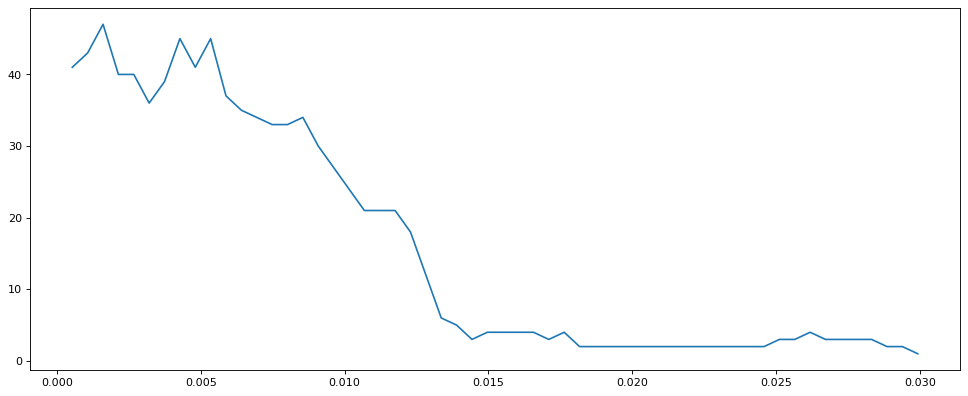

In [16]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 6), dpi=80)
plt.plot(eps_nums, eps_num_clusters)
#plt.plot(eps_nums, eps_num_noise)
plt.show()

In [17]:
print("Taking EPS as", 0.006)
# Compute DBSCAN
db = DBSCAN(eps=0.006, min_samples=5, metric="precomputed", n_jobs=4).fit(input_similarity_matrix)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Taking EPS as 0.006
Estimated number of clusters: 36
Estimated number of noise points: 3570


In [18]:
# Plot result

# Black removed and is used for noise instead.
"""
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        continue

    class_member_mask = (labels == k)

    xy = input_similarity_matrix.iloc[:, 0][class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = input_similarity_matrix.iloc[:, 0][class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'x', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()
"""

"\nunique_labels = set(labels)\ncolors = [plt.cm.Spectral(each)\n          for each in np.linspace(0, 1, len(unique_labels))]\nfor k, col in zip(unique_labels, colors):\n    if k == -1:\n        # Black used for noise.\n        col = [0, 0, 0, 1]\n        continue\n\n    class_member_mask = (labels == k)\n\n    xy = input_similarity_matrix.iloc[:, 0][class_member_mask & core_samples_mask]\n    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),\n             markeredgecolor='k', markersize=14)\n\n    xy = input_similarity_matrix.iloc[:, 0][class_member_mask & ~core_samples_mask]\n    plt.plot(xy[:, 0], xy[:, 1], 'x', markerfacecolor=tuple(col),\n             markeredgecolor='k', markersize=6)\n\nplt.title('Estimated number of clusters: %d' % n_clusters_)\nplt.show()\n"

In [19]:

from collections import Counter

for unique_label in set(labels):
    
    class_member_mask = (labels == unique_label)
    print("In cluster", unique_label, "found", Counter(class_member_mask)[True], "points")
    print("Samples")
    print(np.array(input_texts)[class_member_mask])
    print("-------------------------------------")
    #print(Counter(class_member_mask).keys()) # equals to list(set(words))
    #Counter(words).values() # counts the elements' frequency


In cluster 0 found 1005 points
Samples
['do you like comic books' 'hi do you like fish' 'do you like baseball'
 ... 'hi how are you' 'great do you follow politics'
 'hello do you follow football']
-------------------------------------
In cluster 1 found 25 points
Samples
['have a good evening.' 'have a good evening.' 'have a good night.'
 'have a good night.' 'have a good night.' 'have a good night.'
 'have a good night.' 'have a good night.' 'have a good night.'
 'have a good night.' 'have a good evening.' 'have a good night.'
 'have a good night.' 'have a good night.' 'have a good evening.'
 'have a good night.' 'have a good night.' 'have a good night.'
 'have a good night.' 'have a good evening.' 'have a good night.'
 'have a good night.' 'have a good night.' 'have a good night.'
 'have a good night.']
-------------------------------------
In cluster 2 found 33 points
Samples
['thanks you too.' 'thank you you as well.' 'you too. thanks.'
 'you too thank you.' 'thanks. you too.' 'tha

In [20]:
with open('input_dbscan.pickle', 'wb') as handle:
    pickle.dump(db, handle, protocol=pickle.HIGHEST_PROTOCOL)